In [1]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tcn import TCN

In [2]:
# Use an old model

model = load_model('saved_model/tcn_model_0.5_classified.h5', custom_objects={'TCN': TCN})

demand_weather_merged = pd.read_parquet('data/demand_weather_merged_0.5.parquet')

label_encoder = LabelEncoder()

features = demand_weather_merged[['temperature_2m', 'precipitation', 'month', 
                                   'snow_depth', 'pressure_msl', 'cloud_cover', 
                                   'sunshine_duration', 
                                   'day_of_week', 'building_id_encoded']]
target = demand_weather_merged['y']

target_log_transformed = np.log1p(target)
target_clipped = np.clip(target_log_transformed, target_log_transformed.quantile(0.05), target_log_transformed.quantile(0.95))

features_df = pd.DataFrame(features)
constant_features = features_df.columns[features_df.nunique() <= 1]
features_df = features_df.drop(columns=constant_features)


# Input sequence for forecasting in the model window_size = weeks
window_size = 4

def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X, dtype='float32'), np.array(y, dtype='float32')

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

X, y = create_sequences(features_scaled, target_log_transformed.values, window_size)
building_ids = features_df['building_id_encoded'].values[window_size:]

# Changing continuous variable in dataset to discrete for classification
bin_edges = [0, 28, 56, 84, np.inf]
num_classes = len(bin_edges) - 1

demand_weather_merged['y_bin'] = np.digitize(demand_weather_merged['y'], bins=bin_edges, right=False) - 1
y_bin_sequenced = demand_weather_merged['y_bin'].values[window_size:]

# 80% training and 20% temp
X_train, X_temp, y_train, y_temp, train_building_ids, temp_building_ids = train_test_split(
    X, y_bin_sequenced, building_ids, test_size=0.2, random_state=42
)

# Split the 20% temp set into 50% validation and 50% test
X_val, X_test, y_val, y_test, val_building_ids, test_building_ids = train_test_split(
    X_temp, y_temp, temp_building_ids, test_size=0.5, random_state=42
)

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

y_pred = model.predict([X_test, test_building_ids])

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

1580/1580 [==============================] - 6s 2ms/step



Classification Metrics:
Accuracy: 0.8343
Precision: 0.8339
Recall: 0.8343
F1 Score: 0.8338

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     25560
           1       0.78      0.82      0.80     17641
           2       0.65      0.59      0.61      4558
           3       0.79      0.76      0.78      2796

    accuracy                           0.83     50555
   macro avg       0.78      0.77      0.77     50555
weighted avg       0.83      0.83      0.83     50555



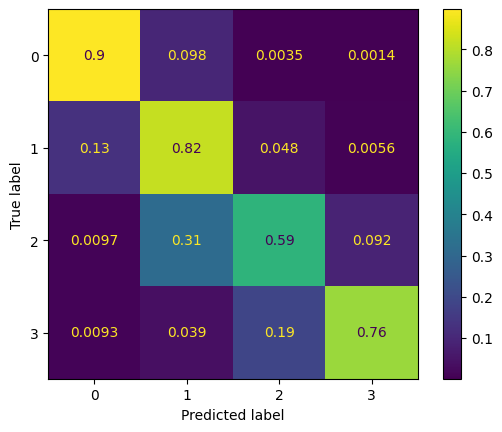

In [3]:
# Metric analysis

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f"\nClassification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

ConfusionMatrixDisplay.from_predictions(y_test_classes, y_pred_classes, normalize='true')
plt.show()